In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn import linear_model

In [66]:
df_music = pd.read_csv('../music_data/billboard_top_100_1960_1969.csv')

In [67]:
df_music.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount
count,1000.000000,1000,1000,1000.000000,1.000000e+03
unique,NaN,551,987,NaN,NaN
top,NaN,The Beatles,Groovin',NaN,NaN
freq,NaN,23,2,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,7.899716e+06
std,28.922799,NaN,NaN,2.875111,1.992259e+07
min,1.000000,NaN,NaN,1960.000000,1.554000e+03
25%,25.750000,NaN,NaN,1962.000000,2.437070e+05
50%,50.500000,NaN,NaN,1964.500000,8.641245e+05
75%,76.000000,NaN,NaN,1967.000000,4.963935e+06


# 1 Visualization

## 1.1 Heat Map: Correlation

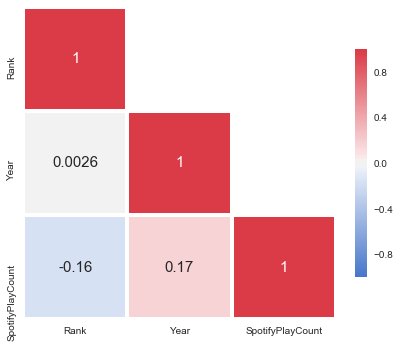

In [68]:
sns.set(style="white")
corr = df_music.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

## 1.2 Histogram: Play Count (Original)

In [69]:
df_playCount = df_music.SpotifyPlayCount

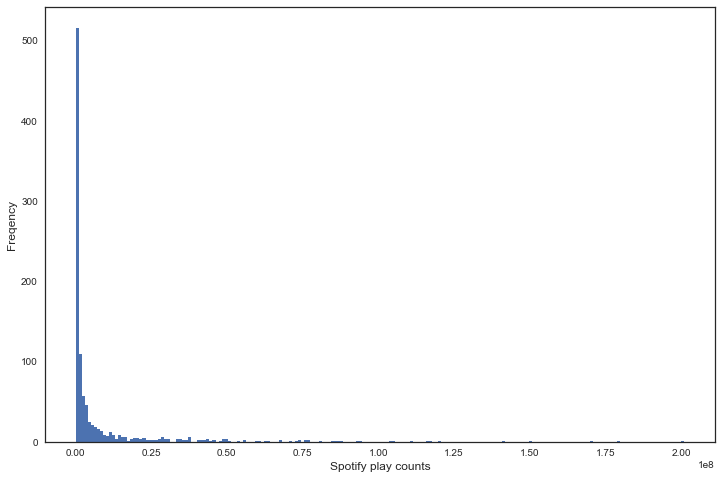

In [70]:
ax = df_playCount.plot.hist(bins=200, figsize=(12,8))
ax.set_xlabel("Spotify play counts", fontsize=12)
ax.set_ylabel("Freqency", fontsize=12)

In [71]:
df_playCount2 = df_music[df_music.SpotifyPlayCount < 1000000]

In [72]:
df_playCount2.shape

(513, 5)

The play count distribution is largely **skewed**. The biggest play count is over 200 million, while 513 out of 1000 songs have a play count lower than 1 million.

## 1.3 Histogram: Play Count (Logarithm)

In [73]:
df_playCount3 = np.log(df_music.SpotifyPlayCount)

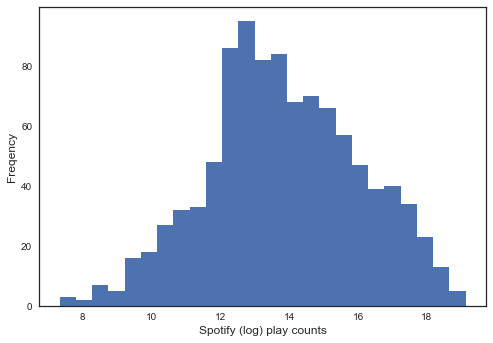

In [74]:
ax = df_playCount3.plot.hist(bins=25)
ax.set_xlabel("Spotify (log) play counts", fontsize=12)
ax.set_ylabel("Freqency", fontsize=12)

After logarithm, the distribution looks much like **bell shape**. It makes sense to change our original target to the log-target.

## 1.4 Heat Map: Correlation with Log Target

The following correlation heat map with **log** target is **better** than the correlation heat map with **original** target. A higher correlation implys that we are more likely to build a model with lower error.

In [75]:
df_music_clean = df_music.copy()
df_music_clean.SpotifyPlayCount = np.log(df_music_clean.SpotifyPlayCount)
df_music_clean.rename(columns={'SpotifyPlayCount':'LogPlayCount'}, inplace=True)

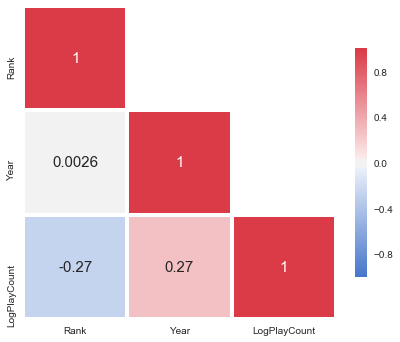

In [91]:
sns.set(style="white")
corr = df_music_clean.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})


## 1.5 Bar: Frequency of Artists

The frequency of each artist. The Beatles has the highest frequency with 23 times.

In [120]:
ser_artists = df_music_clean.Artist   # 1000 artists
arr_artists = ser_artists.unique()    # 551 unique artists

Use a dictionary to count the frequency of each unique artist.

In [121]:
dic_artist_count = {} 

In [122]:
for i in arr_artists:
    dic_artist_count[i] = 0
    
for i in ser_artists:
    dic_artist_count[i] = dic_artist_count[i] + 1

In [180]:
frequency = dic_artist_count.values()
list_frequency = list(frequency)  
ser_frequency = pd.Series(list_frequency)

Use a dictionary to count the frequency of the **frequency of each unique artist**.

In [188]:
dic_frequency_count = {}

In [189]:
arr_frequency = ser_frequency.unique()

for i in arr_frequency:
    dic_frequency_count[i] = 0
    
for i in ser_frequency:
    dic_frequency_count[i] = dic_frequency_count[i] + 1

There are 373 artists who show up once in the chart. There is one artist who show up 23 times, which is The Beatles.

In [190]:
dic_frequency_count

{1: 373,
 2: 81,
 3: 38,
 4: 19,
 5: 17,
 6: 8,
 7: 7,
 8: 2,
 9: 1,
 10: 1,
 11: 2,
 13: 1,
 23: 1}

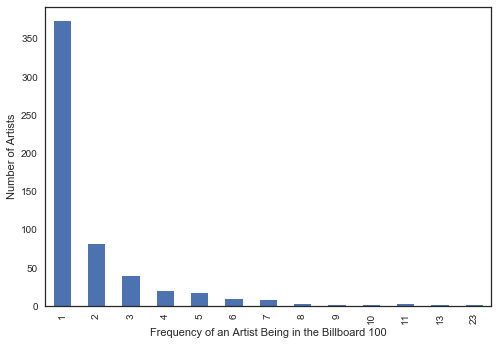

In [199]:
ser_frequency_count = pd.Series(dic_frequency_count)
ax = ser_frequency_count.plot.bar()
ax.set_xlabel('Frequency of an Artist Being in the Billboard 100')
ax.set_ylabel('Number of Artists')

# 2 Baseline Model

## 2.1 Z-score the Features

In [8]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

In [24]:
z_score_norm(df_music_clean, feature_list=['Rank', 'Year'])

In [25]:
df_music_clean.head()

,Rank,Artist,Title,Year,LogPlayCount
0,-1.713078,Percy Faith,"Theme From ""A Summer Place""",-1.565505,15.425179
1,-1.678503,Jim Reeves,He'll Have To Go,-1.565505,15.291952
2,-1.643928,Everly Brothers,Cathy's Clown,-1.565505,15.246003
3,-1.609353,Johnny Preston,Running Bear,-1.565505,14.183606
4,-1.574778,Mark Dinning,Teen Angel,-1.565505,12.986026


## 2.2 Do the Linear Regression

Extract target and features

In [27]:
target = df_music_clean.loc[:,'LogPlayCount']
feature = df_music_clean.loc[:,['Rank', 'Year']]

In [31]:
feature.shape

(1000, 2)

# 3 Evaluation

In [28]:
feature

,Rank,Year
0,-1.713078,-1.565505
1,-1.678503,-1.565505
2,-1.643928,-1.565505
3,-1.609353,-1.565505
4,-1.574778,-1.565505
5,-1.540204,-1.565505
6,-1.505629,-1.565505
7,-1.471054,-1.565505
8,-1.436479,-1.565505
9,-1.401904,-1.565505


In [9]:
df_music_clean.head()

,Rank,Artist,Title,Year,SpotifyPlayCount
0,1,Percy Faith,"Theme From ""A Summer Place""",1960,15.425179
1,2,Jim Reeves,He'll Have To Go,1960,15.291952
2,3,Everly Brothers,Cathy's Clown,1960,15.246003
3,4,Johnny Preston,Running Bear,1960,14.183606
4,5,Mark Dinning,Teen Angel,1960,12.986026
